<a href="https://colab.research.google.com/github/Aneesh-CQ/Aneesh-CQ.github.io/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
# Load the CSV file
df = pd.read_csv('/content/Fraud.csv')

# Check the first few rows
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,0.0


Missing values:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     1
newbalanceOrig    1
nameDest          1
oldbalanceDest    1
newbalanceDest    1
isFraud           1
isFlaggedFraud    1
dtype: int64


<ipython-input-5-bbe0832f9232>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['oldbalanceDest'].fillna(0, inplace=True)
<ipython-input-5-bbe0832f9232>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

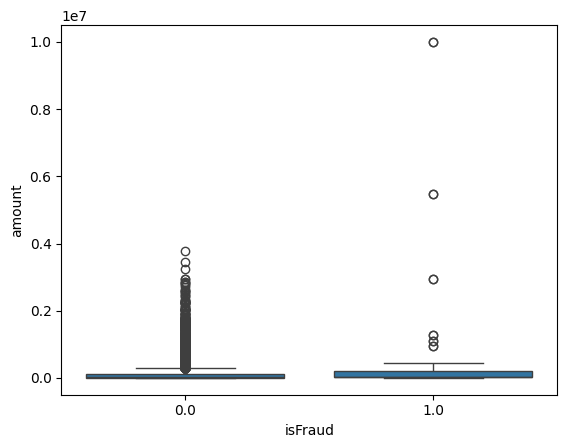

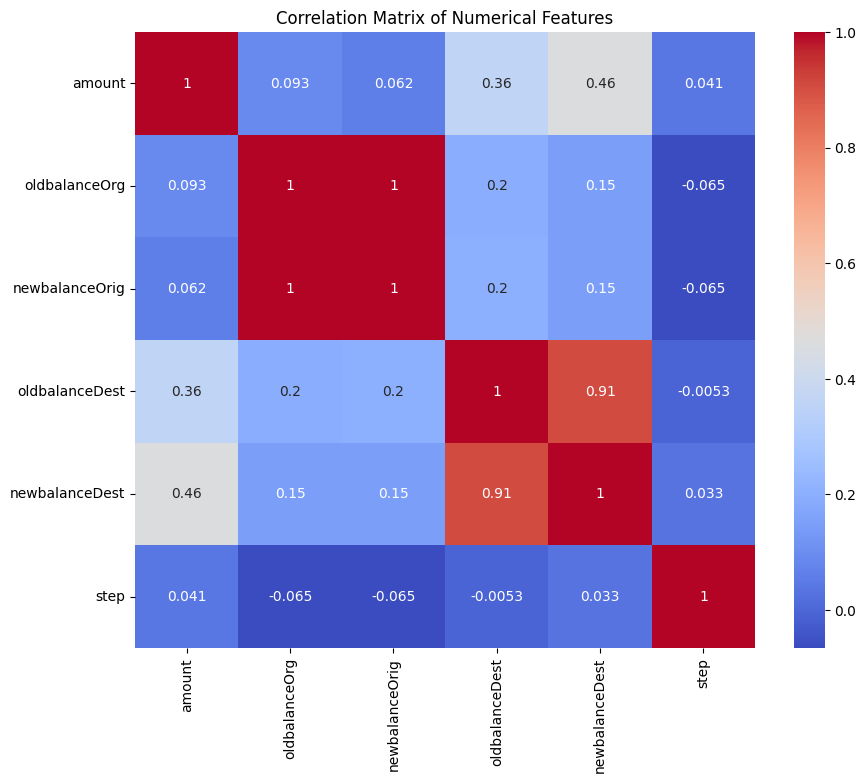

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Handle missing values for balance columns with merchants
df['oldbalanceDest'].fillna(0, inplace=True)
df['newbalanceDest'].fillna(0, inplace=True)

# Check for outliers using transaction amounts
sns.boxplot(x='isFraud', y='amount', data=df)
plt.show()

# Drop irrelevant columns (e.g., 'nameOrig', 'nameDest' since they're IDs)
df_cleaned = df.drop(['nameOrig', 'nameDest'], axis=1)

# Drop categorical or one-hot encoded columns for correlation matrix calculation
numeric_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'step']

# Calculate correlation matrix for numerical features only
correlation_matrix = df_cleaned[numeric_columns].corr()

# Plot the correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features")
plt.show()

# Based on the heatmap, decide if any features should be dropped


In [ ]:
# Function to remove outliers
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Example: Remove outliers in 'amount' column
df_cleaned = remove_outliers_iqr(df, 'amount')
print("Dataset after removing outliers in 'amount':", df_cleaned.shape)


Dataset after removing outliers in 'amount': (12772, 11)


In [ ]:
# Create new features to capture the balance difference
df_cleaned['balance_diff_orig'] = df_cleaned['newbalanceOrig'] - df_cleaned['oldbalanceOrg']
df_cleaned['balance_diff_dest'] = df_cleaned['newbalanceDest'] - df_cleaned['oldbalanceDest']

# Now drop the original balance columns
df_cleaned = df_cleaned.drop(['newbalanceOrig', 'oldbalanceOrg', 'newbalanceDest', 'oldbalanceDest'], axis=1)


<ipython-input-8-6adfd14c203a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['balance_diff_orig'] = df_cleaned['newbalanceOrig'] - df_cleaned['oldbalanceOrg']
<ipython-input-8-6adfd14c203a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['balance_diff_dest'] = df_cleaned['newbalanceDest'] - df_cleaned['oldbalanceDest']


In [ ]:
# Check the columns of df_cleaned
print("Columns in df_cleaned:", df_cleaned.columns)

# If 'type' doesn't exist, check if it is in the original df
print("Columns in df:", df.columns)

Columns in df_cleaned: Index(['step', 'type', 'amount', 'nameOrig', 'nameDest', 'isFraud',
       'isFlaggedFraud', 'balance_diff_orig', 'balance_diff_dest'],
      dtype='object')
Columns in df: Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


In [ ]:
if 'type' not in df_cleaned.columns and 'type' in df.columns:
    df_cleaned['type'] = df['type']

In [ ]:
# Create dummy variables for 'type' (transaction type)
df_cleaned = pd.get_dummies(df_cleaned, columns=['type'], drop_first=True)

# Check for missing values in the target variable
print("Missing values in 'isFraud':", df['isFraud'].isnull().sum())

# Option 1: Drop rows where the target 'isFraud' has missing values
df_cleaned = df_cleaned.dropna(subset=['isFraud'])

# Option 2 (if you'd prefer to fill the NaN values):
# You can fill missing values in 'isFraud' with the most frequent value (0 or 1), for example:
# df_cleaned['isFraud'].fillna(df_cleaned['isFraud'].mode()[0], inplace=True)

# Now redefine X and y after handling missing values
X = df_cleaned.drop(['isFraud', 'isFlaggedFraud'], axis=1)  # Features
y = df_cleaned['isFraud']  # Target

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

In [ ]:
# Checking the distribution of the target variable 'isFraud'
fraud_count = df['isFraud'].value_counts()
print(fraud_count)

# Percentage of fraud vs. non-fraud
fraud_percentage = (fraud_count[1] / fraud_count.sum()) * 100
print(f"Percentage of fraudulent transactions: {fraud_percentage:.2f}%")


In [ ]:
# Import LightGBM
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Prepare dataset for LightGBM
d_train = lgb.Dataset(X_train, label=y_train)

# Set parameters for LightGBM
params = {
    'objective': 'binary',   # Binary classification
    'boosting_type': 'gbdt', # Gradient Boosting Decision Tree
    'metric': 'binary_logloss', # Evaluation metric
    'learning_rate': 0.05,  # Learning rate
    'scale_pos_weight': fraud_count[0] / fraud_count[1],
    'num_leaves': 31,       # Max leaves in a tree
    'max_depth': -1,        # No limit on depth
    'feature_fraction': 0.8, # Fraction of features to be used
    'bagging_fraction': 0.8, # Subsample ratio
    'bagging_freq': 5,       # Perform bagging every 5 iterations
    'verbose': -1            # Suppress output
}

# Train the model
lgbm_model = lgb.train(params, d_train, num_boost_round=200)

# Predictions on the test set
y_pred_prob = lgbm_model.predict(X_test)

# Convert probabilities into binary output (0 or 1) using a threshold of 0.5
y_pred = [1 if x >= 0.5 else 0 for x in y_pred_prob]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot Feature Importance
lgb.plot_importance(lgbm_model, max_num_features=10, importance_type='gain')
plt.show()
